In [1]:
import os
import time
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter

from albumentations import Compose, Resize, Normalize, HorizontalFlip, RandomBrightnessContrast
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from efficientnet_pytorch import EfficientNet

# Check system
print("="*70)
print("SYSTEM INFORMATION")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print("="*70)


SYSTEM INFORMATION
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
GPU Memory: 8.59 GB


In [2]:
# ========================================================================
# EXTRACT DATASET
# ========================================================================

# CHANGE THIS to your actual zip file path
zip_path = "path/to/your/nih_chest_xray.zip"  # ← UPDATE THIS
extract_path = "./chest_xray_data/"

os.makedirs(extract_path, exist_ok=True)

# Extract (skip if already done)
if not os.path.exists(os.path.join(extract_path, "Data_Entry_2017.csv")):
    print("Extracting dataset (this may take 10-15 minutes)...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted!")
else:
    print("✅ Dataset already extracted!")

# Check size
def get_folder_size(path):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.exists(fp):
                total += os.path.getsize(fp)
    return total / (1024**3)

dataset_size = get_folder_size(extract_path)
print(f"\n📊 Dataset size: {dataset_size:.2f} GB")
if dataset_size > 30:
    print("⚠️ Large dataset detected - optimizations applied")


✅ Dataset already extracted!

📊 Dataset size: 41.98 GB
⚠️ Large dataset detected - optimizations applied


In [3]:
# ========================================================================
# LOAD DATASET
# ========================================================================

data_entry = pd.read_csv(os.path.join(extract_path, "Data_Entry_2017.csv"))

print("="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Total images: {len(data_entry):,}")
print(f"Unique patients: {data_entry['Patient ID'].nunique():,}")
print(f"\nColumns: {list(data_entry.columns)}")
print(f"\nFirst rows:")
print(data_entry.head())

print("\n" + "="*70)
print("TOP 15 DISEASE COMBINATIONS")
print("="*70)
print(data_entry['Finding Labels'].value_counts().head(15))


DATASET INFORMATION
Total images: 112,120
Unique patients: 30,805

Columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

First rows:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA     

In [4]:
# ========================================================================
# DATASET SPLIT - FULL OR SUBSET
# ========================================================================

# TRAINING MODE SELECTION
TRAINING_MODE = 2  # Change this:
# 1 = Quick test (20% data, ~2 hours)
# 2 = Full training (100% data, ~6-8 hours)

print("\n" + "="*70)
print("TRAINING MODE CONFIGURATION")
print("="*70)

if TRAINING_MODE == 1:
    print("MODE 1: QUICK TEST (20% subset)")
    print("  Purpose: Code testing, debugging, quick experiments")
    print("  Time: ~2 hours")
    print("  Expected AUC: ~72-76%")
    USE_SUBSET = True
    SUBSET_FRACTION = 0.2
elif TRAINING_MODE == 2:
    print("MODE 2: FULL TRAINING (100% data)")
    print("  Purpose: Final model, publication-ready results")
    print("  Time: ~6-8 hours")
    print("  Expected AUC: ~78-82%")
    USE_SUBSET = False
    SUBSET_FRACTION = 1.0

print("="*70)

# Load splits
train_list_path = os.path.join(extract_path, "train_val_list.txt")
test_list_path = os.path.join(extract_path, "test_list.txt")

if os.path.exists(train_list_path) and os.path.exists(test_list_path):
    print("\n✅ Using official train/test split")
    train_list = pd.read_csv(train_list_path, header=None)[0].tolist()
    test_list = pd.read_csv(test_list_path, header=None)[0].tolist()
    train_val_data = data_entry[data_entry['Image Index'].isin(train_list)].reset_index(drop=True)
    test_data = data_entry[data_entry['Image Index'].isin(test_list)].reset_index(drop=True)
else:
    print("\n⚠️ Official split not found, creating custom split")
    train_val_data, test_data = train_test_split(data_entry, test_size=0.3, random_state=42)

# Split train/val
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

print(f"\nOriginal sizes:")
print(f"  Train:      {len(train_data):,}")
print(f"  Validation: {len(val_data):,}")
print(f"  Test:       {len(test_data):,}")

# Apply subset if needed
if USE_SUBSET:
    train_data = train_data.sample(frac=SUBSET_FRACTION, random_state=42).reset_index(drop=True)
    val_data = val_data.sample(frac=SUBSET_FRACTION, random_state=42).reset_index(drop=True)
    test_data = test_data.sample(frac=SUBSET_FRACTION, random_state=42).reset_index(drop=True)
    print(f"\n⚠️ Using {SUBSET_FRACTION*100:.0f}% subset")

print(f"\nFinal sizes:")
print(f"  Train:      {len(train_data):,}")
print(f"  Validation: {len(val_data):,}")
print(f"  Test:       {len(test_data):,}")



TRAINING MODE CONFIGURATION
MODE 2: FULL TRAINING (100% data)
  Purpose: Final model, publication-ready results
  Time: ~6-8 hours
  Expected AUC: ~78-82%

✅ Using official train/test split

Original sizes:
  Train:      69,219
  Validation: 17,305
  Test:       25,596

Final sizes:
  Train:      69,219
  Validation: 17,305
  Test:       25,596


In [5]:
# ========================================================================
# DATA AUGMENTATION (Optimized for 45GB dataset)
# ========================================================================

IMAGE_SIZE = 128  # 128 for speed, 224 for quality

train_transforms = Compose([
    Resize(IMAGE_SIZE, IMAGE_SIZE),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = Compose([
    Resize(IMAGE_SIZE, IMAGE_SIZE),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("="*70)
print("DATA AUGMENTATION")
print("="*70)
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print("Augmentations: Minimal (optimized for speed)")
print("  ✓ Resize")
print("  ✓ Horizontal flip")
print("  ✓ Brightness/Contrast")
print("  ✓ Normalization")
print("="*70)


DATA AUGMENTATION
Image size: 128x128
Augmentations: Minimal (optimized for speed)
  ✓ Resize
  ✓ Horizontal flip
  ✓ Brightness/Contrast
  ✓ Normalization


In [6]:
# ========================================================================
# CUSTOM DATASET CLASS
# ========================================================================

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, num_classes=14):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.num_classes = num_classes
        
        self.pathologies = [
            'Atelectasis', 'Consolidation', 'Infiltration', 
            'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 
            'Effusion', 'Pneumonia', 'Pleural_Thickening', 
            'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
        ]
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        
        # Check multiple possible image locations
        possible_paths = [
            os.path.join(self.img_dir, 'images', img_name),
            os.path.join(self.img_dir, img_name),
        ]
        
        # Add numbered folder paths (images_001 to images_012)
        for i in range(1, 13):
            possible_paths.append(
                os.path.join(self.img_dir, f'images_{i:03d}', 'images', img_name)
            )
        
        img_path = None
        for path in possible_paths:
            if os.path.exists(path):
                img_path = path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Image not found: {img_name}")
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Create label vector
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = np.zeros(self.num_classes, dtype=np.float32)
        
        if labels_str != 'No Finding':
            for i, pathology in enumerate(self.pathologies):
                if pathology in labels_str:
                    labels[i] = 1.0
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, torch.tensor(labels)

print("✅ Dataset class defined")


✅ Dataset class defined


In [7]:
# ========================================================================
# CREATE DATALOADERS (Optimized for 45GB dataset)
# ========================================================================

BATCH_SIZE = 64
NUM_WORKERS = 0  # Best for slow disk
PIN_MEMORY = False

print("="*70)
print("DATALOADER CONFIGURATION")
print("="*70)
print(f"Image size:   {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Batch size:   {BATCH_SIZE}")
print(f"Num workers:  {NUM_WORKERS}")
print(f"Pin memory:   {PIN_MEMORY}")
print("="*70)

# Create datasets
train_dataset = ChestXrayDataset(train_data, img_dir=extract_path, transform=train_transforms)
val_dataset = ChestXrayDataset(val_data, img_dir=extract_path, transform=val_transforms)
test_dataset = ChestXrayDataset(test_data, img_dir=extract_path, transform=val_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"\n✅ Dataloaders created:")
print(f"   Train: {len(train_loader):,} batches ({len(train_dataset):,} images)")
print(f"   Val:   {len(val_loader):,} batches ({len(val_dataset):,} images)")
print(f"   Test:  {len(test_loader):,} batches ({len(test_dataset):,} images)")


DATALOADER CONFIGURATION
Image size:   128x128
Batch size:   64
Num workers:  0
Pin memory:   False

✅ Dataloaders created:
   Train: 1,082 batches (69,219 images)
   Val:   271 batches (17,305 images)
   Test:  400 batches (25,596 images)


In [8]:
# ========================================================================
# CALCULATE CLASS WEIGHTS
# ========================================================================

def calculate_class_weights(dataframe, num_classes=14):
    pathologies = [
        'Atelectasis', 'Consolidation', 'Infiltration', 
        'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 
        'Effusion', 'Pneumonia', 'Pleural_Thickening', 
        'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
    ]
    
    total_samples = len(dataframe)
    pos_weights = []
    
    print("\n" + "="*70)
    print("CLASS DISTRIBUTION")
    print("="*70)
    print(f"{'Disease':<25} {'Count':<10} {'%':<10} {'Weight':<10}")
    print("-"*70)
    
    for pathology in pathologies:
        pos_count = dataframe['Finding Labels'].str.contains(pathology, regex=False).sum()
        neg_count = total_samples - pos_count
        weight = neg_count / pos_count if pos_count > 0 else 1.0
        pos_weights.append(weight)
        percentage = (pos_count / total_samples) * 100
        print(f"{pathology:<25} {pos_count:<10} {percentage:<10.2f} {weight:<10.2f}")
    
    print("="*70)
    return torch.tensor(pos_weights, dtype=torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = calculate_class_weights(train_data)
class_weights = class_weights.to(device)

print(f"\n✅ Class weights calculated and moved to {device}")



CLASS DISTRIBUTION
Disease                   Count      %          Weight    
----------------------------------------------------------------------
Atelectasis               6575       9.50       9.53      
Consolidation             2244       3.24       29.85     
Infiltration              11034      15.94      5.27      
Pneumothorax              2098       3.03       31.99     
Edema                     1122       1.62       60.69     
Emphysema                 1127       1.63       60.42     
Fibrosis                  984        1.42       69.34     
Effusion                  6896       9.96       9.04      
Pneumonia                 696        1.01       98.45     
Pleural_Thickening        1765       2.55       38.22     
Cardiomegaly              1348       1.95       50.35     
Nodule                    3787       5.47       17.28     
Mass                      3226       4.66       20.46     
Hernia                    110        0.16       628.26    

✅ Class weights calcula

In [9]:
# ========================================================================
# MODEL ARCHITECTURE
# ========================================================================

class ChestXrayClassifier(nn.Module):
    def __init__(self, num_classes=14, pretrained=True):
        super(ChestXrayClassifier, self).__init__()
        
        if pretrained:
            self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        else:
            self.backbone = EfficientNet.from_name('efficientnet-b0')
        
        num_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Initialize model
model = ChestXrayClassifier(num_classes=14, pretrained=True)
model = model.to(device)

print("\n" + "="*70)
print("MODEL INFORMATION")
print("="*70)
print(f"Architecture:     EfficientNet-B0")
print(f"Device:           {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable:        {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("="*70)


Loaded pretrained weights for efficientnet-b0

MODEL INFORMATION
Architecture:     EfficientNet-B0
Device:           cuda
Total parameters: 4,025,482
Trainable:        4,025,482


In [10]:
# ========================================================================
# TRAINING CONFIGURATION
# ========================================================================

# Loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Optimizer
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7)

# Mixed precision
scaler = GradScaler()

# Hyperparameters
NUM_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 7

# Experiment directory
experiment_name = f"chest_xray_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(f'experiments/{experiment_name}', exist_ok=True)

# TensorBoard
writer = SummaryWriter(f'experiments/{experiment_name}/logs')

# Configuration
config = {
    'model': 'EfficientNet-B0',
    'image_size': IMAGE_SIZE,
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'subset': USE_SUBSET,
    'subset_fraction': SUBSET_FRACTION if USE_SUBSET else 1.0,
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'num_epochs': NUM_EPOCHS,
    'early_stopping': EARLY_STOPPING_PATIENCE,
    'device': str(device),
    'training_mode': TRAINING_MODE
}

with open(f'experiments/{experiment_name}/config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)
for key, value in config.items():
    print(f"{key:<20}: {value}")
print("="*70)



TRAINING CONFIGURATION
model               : EfficientNet-B0
image_size          : 128
batch_size          : 64
num_workers         : 0
subset              : False
subset_fraction     : 1.0
learning_rate       : 0.0001
weight_decay        : 1e-05
num_epochs          : 30
early_stopping      : 7
device              : cuda
training_mode       : 2


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\1498242039.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [11]:
# ========================================================================
# TRAINING FUNCTIONS
# ========================================================================

def train_epoch(model, loader, criterion, optimizer, device, epoch, scaler):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    print(f"\n🔄 Training Epoch {epoch+1}")
    epoch_start = time.time()
    
    for batch_idx, (images, labels) in enumerate(loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        if batch_idx % 5 == 0:
            all_labels.append(labels.cpu().numpy())
            predictions = torch.sigmoid(outputs).detach().cpu().numpy()
            all_predictions.append(predictions)
        
        if (batch_idx + 1) % 50 == 0:
            avg_loss = running_loss / (batch_idx + 1)
            elapsed = time.time() - epoch_start
            speed = (batch_idx + 1) / elapsed
            eta = (len(loader) - batch_idx - 1) / speed / 60
            print(f"  [{batch_idx+1}/{len(loader)}] Loss: {avg_loss:.4f} | "
                  f"{speed:.2f} batch/s | ETA: {eta:.1f}min")
    
    if len(all_labels) > 0:
        all_labels = np.vstack(all_labels)
        all_predictions = np.vstack(all_predictions)
        avg_loss = running_loss / len(loader)
        try:
            auc_macro = roc_auc_score(all_labels, all_predictions, average='macro')
            auc_weighted = roc_auc_score(all_labels, all_predictions, average='weighted')
        except:
            auc_macro = 0.0
            auc_weighted = 0.0
    else:
        avg_loss = running_loss / len(loader)
        auc_macro = 0.0
        auc_weighted = 0.0
    
    return avg_loss, auc_macro, auc_weighted


def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            all_labels.append(labels.cpu().numpy())
            predictions = torch.sigmoid(outputs).cpu().numpy()
            all_predictions.append(predictions)
    
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    avg_loss = running_loss / len(loader)
    
    auc_macro = roc_auc_score(all_labels, all_predictions, average='macro')
    auc_weighted = roc_auc_score(all_labels, all_predictions, average='weighted')
    
    per_class_auc = []
    for i in range(all_labels.shape[1]):
        try:
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            per_class_auc.append(auc)
        except:
            per_class_auc.append(0.0)
    
    return avg_loss, auc_macro, auc_weighted, per_class_auc


def calculate_metrics(labels, predictions, threshold=0.5):
    binary_preds = (predictions >= threshold).astype(int)
    accuracy = accuracy_score(labels.flatten(), binary_preds.flatten())
    f1_macro = f1_score(labels, binary_preds, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, binary_preds, average='weighted', zero_division=0)
    return accuracy, f1_macro, f1_weighted

print("✅ Training functions defined")


✅ Training functions defined


In [12]:
# ========================================================================
# MAIN TRAINING LOOP
# ========================================================================

def train_model():
    best_val_auc = 0.0
    early_stop_counter = 0
    training_start_time = time.time()
    
    pathologies = [
        'Atelectasis', 'Consolidation', 'Infiltration', 
        'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 
        'Effusion', 'Pneumonia', 'Pleural_Thickening', 
        'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
    ]
    
    print("\n" + "="*70)
    print("🚀 STARTING TRAINING")
    print("="*70)
    print(f"Mode: {'Subset (20%)' if USE_SUBSET else 'Full Dataset (100%)'}")
    print(f"Training images: {len(train_data):,}")
    if TRAINING_MODE == 1:
        print(f"Expected time: ~2 hours")
        print(f"Target AUC: 72-76%")
    else:
        print(f"Expected time: ~6-8 hours")
        print(f"Target AUC: 78-82%")
    print("="*70)
    
    for epoch in range(NUM_EPOCHS):
        epoch_start = time.time()
        
        print(f"\n{'='*70}")
        print(f"EPOCH [{epoch+1}/{NUM_EPOCHS}]")
        print(f"{'='*70}")
        
        # Train
        train_loss, train_auc_macro, train_auc_weighted = train_epoch(
            model, train_loader, criterion, optimizer, device, epoch, scaler
        )
        
        # Validate
        val_loss, val_auc_macro, val_auc_weighted, per_class_auc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Update LR
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_auc_macro)
        current_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != current_lr:
            print(f"\n📉 LR: {old_lr:.2e} → {current_lr:.2e}")
        
        epoch_time = time.time() - epoch_start
        total_elapsed = (time.time() - training_start_time) / 3600
        
        # Log
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('AUC/train', train_auc_macro, epoch)
        writer.add_scalar('AUC/val', val_auc_macro, epoch)
        writer.add_scalar('LR', current_lr, epoch)
        
        for pathology, auc in zip(pathologies, per_class_auc):
            writer.add_scalar(f'AUC_class/{pathology}', auc, epoch)
        
        # Print results
        print(f"\n📊 Results:")
        print(f"  Train: Loss={train_loss:.4f}, AUC={train_auc_macro:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, AUC={val_auc_macro:.4f}")
        print(f"  Time: {epoch_time/60:.1f}min | Total: {total_elapsed:.2f}hrs")
        
        if epoch > 0:
            avg_time = (time.time() - training_start_time) / (epoch + 1)
            eta = (avg_time * (NUM_EPOCHS - epoch - 1)) / 3600
            print(f"  ETA: {eta:.2f} hours")
        
        # Per-class (compact)
        print(f"\n  Per-class AUC:")
        for pathology, auc in zip(pathologies, per_class_auc):
            bar = '█' * int(auc * 20)
            print(f"    {pathology:<22}: {auc:.3f} {bar}")
        
        # Save best
        if val_auc_macro > best_val_auc:
            best_val_auc = val_auc_macro
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auc_macro': val_auc_macro,
                'per_class_auc': per_class_auc,
                'config': config
            }, f'experiments/{experiment_name}/best_model.pth')
            print(f"\n  ✅ Best model saved! AUC: {best_val_auc:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"\n  ⏳ No improvement ({early_stop_counter}/{EARLY_STOPPING_PATIENCE})")
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
        }, f'experiments/{experiment_name}/latest.pth')
        
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⚠️ Early stopping at epoch {epoch+1}")
            break
    
    total_time = time.time() - training_start_time
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print(f"Best AUC: {best_val_auc:.4f}")
    print(f"Time: {total_time/3600:.2f} hours")
    print("="*70)
    
    writer.close()
    return best_val_auc

print("✅ Training function ready")


✅ Training function ready


In [13]:
# ========================================================================
# START TRAINING
# ========================================================================

print("\n" + "🎬 "*35)
print("STARTING TRAINING")
print("🎬 "*35 + "\n")

print(f"⏰ Started: {time.strftime('%I:%M %p IST')}")
if TRAINING_MODE == 1:
    print(f"⏰ Expected completion: ~{time.strftime('%I:%M %p', time.localtime(time.time() + 7200))} IST")
else:
    print(f"⏰ Expected completion: ~{time.strftime('%I:%M %p', time.localtime(time.time() + 28800))} IST")

best_auc = train_model()

print("\n" + "🎉 "*35)
print(f"Training complete! Best AUC: {best_auc:.4f}")
print("🎉 "*35)



🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 
STARTING TRAINING
🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 

⏰ Started: 09:31 AM IST
⏰ Expected completion: ~05:31 PM IST

🚀 STARTING TRAINING
Mode: Full Dataset (100%)
Training images: 69,219
Expected time: ~6-8 hours
Target AUC: 78-82%

EPOCH [1/30]

🔄 Training Epoch 1


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 1.2981 | 0.19 batch/s | ETA: 91.2min
  [100/1082] Loss: 1.3083 | 0.19 batch/s | ETA: 87.0min
  [150/1082] Loss: 1.3140 | 0.19 batch/s | ETA: 82.9min
  [200/1082] Loss: 1.3289 | 0.19 batch/s | ETA: 78.8min
  [250/1082] Loss: 1.3188 | 0.18 batch/s | ETA: 77.2min
  [300/1082] Loss: 1.2969 | 0.18 batch/s | ETA: 73.6min
  [350/1082] Loss: 1.2777 | 0.19 batch/s | ETA: 65.5min
  [400/1082] Loss: 1.2623 | 0.20 batch/s | ETA: 57.8min
  [450/1082] Loss: 1.2630 | 0.21 batch/s | ETA: 51.2min
  [500/1082] Loss: 1.2567 | 0.21 batch/s | ETA: 45.6min
  [550/1082] Loss: 1.2551 | 0.22 batch/s | ETA: 40.4min
  [600/1082] Loss: 1.2507 | 0.23 batch/s | ETA: 35.5min
  [650/1082] Loss: 1.2501 | 0.23 batch/s | ETA: 31.2min
  [700/1082] Loss: 1.2532 | 0.23 batch/s | ETA: 27.2min
  [750/1082] Loss: 1.2537 | 0.24 batch/s | ETA: 23.2min
  [800/1082] Loss: 1.2464 | 0.24 batch/s | ETA: 19.5min
  [850/1082] Loss: 1.2398 | 0.24 batch/s | ETA: 15.9min
  [900/1082] Loss: 1.2371 | 0.25 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=1.2215, AUC=0.6977
  Val:   Loss=1.1471, AUC=0.7708
  Time: 84.8min | Total: 1.41hrs

  Per-class AUC:
    Atelectasis           : 0.761 ███████████████
    Consolidation         : 0.792 ███████████████
    Infiltration          : 0.659 █████████████
    Pneumothorax          : 0.796 ███████████████
    Edema                 : 0.875 █████████████████
    Emphysema             : 0.814 ████████████████
    Fibrosis              : 0.731 ██████████████
    Effusion              : 0.848 ████████████████
    Pneumonia             : 0.668 █████████████
    Pleural_Thickening    : 0.752 ███████████████
    Cardiomegaly          : 0.820 ████████████████
    Nodule                : 0.687 █████████████
    Mass                  : 0.723 ██████████████
    Hernia                : 0.865 █████████████████

  ✅ Best model saved! AUC: 0.7708

EPOCH [2/30]

🔄 Training Epoch 2


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 1.1487 | 0.33 batch/s | ETA: 52.5min
  [100/1082] Loss: 1.1588 | 0.32 batch/s | ETA: 50.5min
  [150/1082] Loss: 1.1575 | 0.32 batch/s | ETA: 48.6min
  [200/1082] Loss: 1.1272 | 0.33 batch/s | ETA: 44.9min
  [250/1082] Loss: 1.1049 | 0.32 batch/s | ETA: 42.9min
  [300/1082] Loss: 1.0963 | 0.32 batch/s | ETA: 40.2min
  [350/1082] Loss: 1.0956 | 0.32 batch/s | ETA: 38.0min
  [400/1082] Loss: 1.0948 | 0.31 batch/s | ETA: 36.3min
  [450/1082] Loss: 1.0859 | 0.31 batch/s | ETA: 34.2min
  [500/1082] Loss: 1.0842 | 0.30 batch/s | ETA: 32.0min
  [550/1082] Loss: 1.0782 | 0.30 batch/s | ETA: 29.4min
  [600/1082] Loss: 1.0747 | 0.30 batch/s | ETA: 27.0min
  [650/1082] Loss: 1.0813 | 0.30 batch/s | ETA: 24.4min
  [700/1082] Loss: 1.0829 | 0.29 batch/s | ETA: 21.6min
  [750/1082] Loss: 1.0828 | 0.29 batch/s | ETA: 18.8min
  [800/1082] Loss: 1.0803 | 0.30 batch/s | ETA: 15.9min
  [850/1082] Loss: 1.0798 | 0.30 batch/s | ETA: 13.1min
  [900/1082] Loss: 1.0782 | 0.30 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=1.0790, AUC=0.7886
  Val:   Loss=1.1377, AUC=0.7862
  Time: 75.3min | Total: 2.67hrs
  ETA: 37.37 hours

  Per-class AUC:
    Atelectasis           : 0.775 ███████████████
    Consolidation         : 0.797 ███████████████
    Infiltration          : 0.666 █████████████
    Pneumothorax          : 0.812 ████████████████
    Edema                 : 0.889 █████████████████
    Emphysema             : 0.852 █████████████████
    Fibrosis              : 0.739 ██████████████
    Effusion              : 0.867 █████████████████
    Pneumonia             : 0.675 █████████████
    Pleural_Thickening    : 0.767 ███████████████
    Cardiomegaly          : 0.856 █████████████████
    Nodule                : 0.686 █████████████
    Mass                  : 0.756 ███████████████
    Hernia                : 0.868 █████████████████

  ✅ Best model saved! AUC: 0.7862

EPOCH [3/30]

🔄 Training Epoch 3


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.9387 | 0.32 batch/s | ETA: 54.0min
  [100/1082] Loss: 0.9466 | 0.31 batch/s | ETA: 52.5min
  [150/1082] Loss: 0.9629 | 0.30 batch/s | ETA: 51.2min
  [200/1082] Loss: 0.9839 | 0.28 batch/s | ETA: 52.0min
  [250/1082] Loss: 0.9877 | 0.27 batch/s | ETA: 51.0min
  [300/1082] Loss: 0.9984 | 0.26 batch/s | ETA: 49.6min
  [350/1082] Loss: 0.9933 | 0.26 batch/s | ETA: 47.3min
  [400/1082] Loss: 0.9912 | 0.25 batch/s | ETA: 44.8min
  [450/1082] Loss: 0.9849 | 0.25 batch/s | ETA: 42.1min
  [500/1082] Loss: 0.9787 | 0.25 batch/s | ETA: 39.0min
  [550/1082] Loss: 0.9765 | 0.25 batch/s | ETA: 35.8min
  [600/1082] Loss: 0.9751 | 0.25 batch/s | ETA: 32.6min
  [650/1082] Loss: 0.9771 | 0.25 batch/s | ETA: 29.3min
  [700/1082] Loss: 0.9749 | 0.25 batch/s | ETA: 25.9min
  [750/1082] Loss: 0.9789 | 0.25 batch/s | ETA: 22.4min
  [800/1082] Loss: 0.9785 | 0.25 batch/s | ETA: 19.0min
  [850/1082] Loss: 0.9835 | 0.25 batch/s | ETA: 15.7min
  [900/1082] Loss: 0.9886 | 0.25 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.9912, AUC=0.8167
  Val:   Loss=1.1410, AUC=0.7913
  Time: 96.0min | Total: 4.27hrs
  ETA: 38.42 hours

  Per-class AUC:
    Atelectasis           : 0.783 ███████████████
    Consolidation         : 0.792 ███████████████
    Infiltration          : 0.676 █████████████
    Pneumothorax          : 0.826 ████████████████
    Edema                 : 0.888 █████████████████
    Emphysema             : 0.855 █████████████████
    Fibrosis              : 0.749 ██████████████
    Effusion              : 0.871 █████████████████
    Pneumonia             : 0.695 █████████████
    Pleural_Thickening    : 0.775 ███████████████
    Cardiomegaly          : 0.868 █████████████████
    Nodule                : 0.698 █████████████
    Mass                  : 0.768 ███████████████
    Hernia                : 0.833 ████████████████

  ✅ Best model saved! AUC: 0.7913

EPOCH [4/30]

🔄 Training Epoch 4


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.9155 | 0.28 batch/s | ETA: 61.1min
  [100/1082] Loss: 0.9175 | 0.28 batch/s | ETA: 58.7min
  [150/1082] Loss: 0.9039 | 0.28 batch/s | ETA: 55.3min
  [200/1082] Loss: 0.9008 | 0.27 batch/s | ETA: 54.1min
  [250/1082] Loss: 0.9015 | 0.27 batch/s | ETA: 52.0min
  [300/1082] Loss: 0.9016 | 0.26 batch/s | ETA: 49.5min
  [350/1082] Loss: 0.9013 | 0.26 batch/s | ETA: 46.8min
  [400/1082] Loss: 0.9041 | 0.26 batch/s | ETA: 43.8min
  [450/1082] Loss: 0.9004 | 0.26 batch/s | ETA: 40.8min
  [500/1082] Loss: 0.9080 | 0.26 batch/s | ETA: 37.7min
  [550/1082] Loss: 0.9033 | 0.26 batch/s | ETA: 34.5min
  [600/1082] Loss: 0.9111 | 0.26 batch/s | ETA: 31.2min
  [650/1082] Loss: 0.9206 | 0.26 batch/s | ETA: 28.0min
  [700/1082] Loss: 0.9233 | 0.26 batch/s | ETA: 24.9min
  [750/1082] Loss: 0.9266 | 0.25 batch/s | ETA: 21.8min
  [800/1082] Loss: 0.9288 | 0.25 batch/s | ETA: 18.5min
  [850/1082] Loss: 0.9384 | 0.25 batch/s | ETA: 15.3min
  [900/1082] Loss: 0.9387 | 0.25 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.9337, AUC=0.8368
  Val:   Loss=1.1943, AUC=0.8005
  Time: 83.6min | Total: 5.66hrs
  ETA: 36.80 hours

  Per-class AUC:
    Atelectasis           : 0.784 ███████████████
    Consolidation         : 0.800 ███████████████
    Infiltration          : 0.683 █████████████
    Pneumothorax          : 0.844 ████████████████
    Edema                 : 0.893 █████████████████
    Emphysema             : 0.866 █████████████████
    Fibrosis              : 0.757 ███████████████
    Effusion              : 0.878 █████████████████
    Pneumonia             : 0.701 ██████████████
    Pleural_Thickening    : 0.786 ███████████████
    Cardiomegaly          : 0.880 █████████████████
    Nodule                : 0.704 ██████████████
    Mass                  : 0.781 ███████████████
    Hernia                : 0.850 █████████████████

  ✅ Best model saved! AUC: 0.8005

EPOCH [5/30]

🔄 Training Epoch 5


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.8497 | 0.36 batch/s | ETA: 47.8min
  [100/1082] Loss: 0.8873 | 0.36 batch/s | ETA: 46.0min
  [150/1082] Loss: 0.8822 | 0.35 batch/s | ETA: 43.9min
  [200/1082] Loss: 0.8703 | 0.35 batch/s | ETA: 42.4min
  [250/1082] Loss: 0.8702 | 0.34 batch/s | ETA: 40.5min
  [300/1082] Loss: 0.8595 | 0.34 batch/s | ETA: 38.6min
  [350/1082] Loss: 0.8634 | 0.34 batch/s | ETA: 36.3min
  [400/1082] Loss: 0.8601 | 0.33 batch/s | ETA: 34.0min
  [450/1082] Loss: 0.8555 | 0.33 batch/s | ETA: 31.8min
  [500/1082] Loss: 0.8573 | 0.33 batch/s | ETA: 29.5min
  [550/1082] Loss: 0.8580 | 0.33 batch/s | ETA: 27.0min
  [600/1082] Loss: 0.8547 | 0.33 batch/s | ETA: 24.5min
  [650/1082] Loss: 0.8570 | 0.32 batch/s | ETA: 22.8min
  [700/1082] Loss: 0.8591 | 0.31 batch/s | ETA: 20.6min
  [750/1082] Loss: 0.8645 | 0.30 batch/s | ETA: 18.3min
  [800/1082] Loss: 0.8647 | 0.30 batch/s | ETA: 15.7min
  [850/1082] Loss: 0.8638 | 0.29 batch/s | ETA: 13.1min
  [900/1082] Loss: 0.8630 | 0.29 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.8660, AUC=0.8488
  Val:   Loss=1.2338, AUC=0.8024
  Time: 81.6min | Total: 7.02hrs
  ETA: 35.11 hours

  Per-class AUC:
    Atelectasis           : 0.787 ███████████████
    Consolidation         : 0.793 ███████████████
    Infiltration          : 0.685 █████████████
    Pneumothorax          : 0.847 ████████████████
    Edema                 : 0.891 █████████████████
    Emphysema             : 0.860 █████████████████
    Fibrosis              : 0.761 ███████████████
    Effusion              : 0.880 █████████████████
    Pneumonia             : 0.719 ██████████████
    Pleural_Thickening    : 0.783 ███████████████
    Cardiomegaly          : 0.885 █████████████████
    Nodule                : 0.704 ██████████████
    Mass                  : 0.791 ███████████████
    Hernia                : 0.846 ████████████████

  ✅ Best model saved! AUC: 0.8024

EPOCH [6/30]

🔄 Training Epoch 6


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.8420 | 0.34 batch/s | ETA: 51.0min
  [100/1082] Loss: 0.8038 | 0.32 batch/s | ETA: 50.4min
  [150/1082] Loss: 0.7940 | 0.32 batch/s | ETA: 48.6min
  [200/1082] Loss: 0.8237 | 0.33 batch/s | ETA: 44.2min
  [250/1082] Loss: 0.8117 | 0.34 batch/s | ETA: 40.7min
  [300/1082] Loss: 0.8105 | 0.34 batch/s | ETA: 38.3min
  [350/1082] Loss: 0.8071 | 0.34 batch/s | ETA: 36.1min
  [400/1082] Loss: 0.8020 | 0.34 batch/s | ETA: 33.6min
  [450/1082] Loss: 0.8076 | 0.34 batch/s | ETA: 31.2min
  [500/1082] Loss: 0.8033 | 0.34 batch/s | ETA: 28.7min
  [550/1082] Loss: 0.8047 | 0.34 batch/s | ETA: 26.2min
  [600/1082] Loss: 0.8056 | 0.34 batch/s | ETA: 23.7min
  [650/1082] Loss: 0.8047 | 0.34 batch/s | ETA: 21.3min
  [700/1082] Loss: 0.8043 | 0.33 batch/s | ETA: 19.0min
  [750/1082] Loss: 0.8104 | 0.33 batch/s | ETA: 16.8min
  [800/1082] Loss: 0.8099 | 0.32 batch/s | ETA: 14.5min
  [850/1082] Loss: 0.8082 | 0.32 batch/s | ETA: 12.2min
  [900/1082] Loss: 0.8094 | 0.31 batch/s | ETA: 9

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.8102, AUC=0.8617
  Val:   Loss=1.3926, AUC=0.7933
  Time: 78.3min | Total: 8.33hrs
  ETA: 33.31 hours

  Per-class AUC:
    Atelectasis           : 0.789 ███████████████
    Consolidation         : 0.800 ███████████████
    Infiltration          : 0.683 █████████████
    Pneumothorax          : 0.841 ████████████████
    Edema                 : 0.886 █████████████████
    Emphysema             : 0.862 █████████████████
    Fibrosis              : 0.750 ██████████████
    Effusion              : 0.882 █████████████████
    Pneumonia             : 0.700 █████████████
    Pleural_Thickening    : 0.779 ███████████████
    Cardiomegaly          : 0.881 █████████████████
    Nodule                : 0.711 ██████████████
    Mass                  : 0.791 ███████████████
    Hernia                : 0.751 ███████████████

  ⏳ No improvement (1/7)

EPOCH [7/30]

🔄 Training Epoch 7


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.7773 | 0.24 batch/s | ETA: 70.3min
  [100/1082] Loss: 0.7841 | 0.24 batch/s | ETA: 66.9min
  [150/1082] Loss: 0.7723 | 0.24 batch/s | ETA: 63.7min
  [200/1082] Loss: 0.7693 | 0.24 batch/s | ETA: 60.2min
  [250/1082] Loss: 0.7635 | 0.24 batch/s | ETA: 57.1min
  [300/1082] Loss: 0.7634 | 0.24 batch/s | ETA: 53.7min
  [350/1082] Loss: 0.7661 | 0.25 batch/s | ETA: 49.4min
  [400/1082] Loss: 0.7692 | 0.25 batch/s | ETA: 45.5min
  [450/1082] Loss: 0.7683 | 0.25 batch/s | ETA: 41.5min
  [500/1082] Loss: 0.7696 | 0.26 batch/s | ETA: 38.0min
  [550/1082] Loss: 0.7681 | 0.26 batch/s | ETA: 34.3min
  [600/1082] Loss: 0.7724 | 0.26 batch/s | ETA: 30.9min
  [650/1082] Loss: 0.7721 | 0.26 batch/s | ETA: 27.5min
  [700/1082] Loss: 0.7737 | 0.26 batch/s | ETA: 24.2min
  [750/1082] Loss: 0.7757 | 0.26 batch/s | ETA: 20.9min
  [800/1082] Loss: 0.7730 | 0.27 batch/s | ETA: 17.7min
  [850/1082] Loss: 0.7726 | 0.27 batch/s | ETA: 14.5min
  [900/1082] Loss: 0.7726 | 0.27 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.7727, AUC=0.8757
  Val:   Loss=1.5236, AUC=0.7968
  Time: 81.8min | Total: 9.69hrs
  ETA: 31.84 hours

  Per-class AUC:
    Atelectasis           : 0.791 ███████████████
    Consolidation         : 0.797 ███████████████
    Infiltration          : 0.685 █████████████
    Pneumothorax          : 0.849 ████████████████
    Edema                 : 0.883 █████████████████
    Emphysema             : 0.853 █████████████████
    Fibrosis              : 0.755 ███████████████
    Effusion              : 0.882 █████████████████
    Pneumonia             : 0.708 ██████████████
    Pleural_Thickening    : 0.778 ███████████████
    Cardiomegaly          : 0.886 █████████████████
    Nodule                : 0.706 ██████████████
    Mass                  : 0.794 ███████████████
    Hernia                : 0.788 ███████████████

  ⏳ No improvement (2/7)

EPOCH [8/30]

🔄 Training Epoch 8


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.6702 | 0.30 batch/s | ETA: 57.2min
  [100/1082] Loss: 0.6706 | 0.30 batch/s | ETA: 55.1min
  [150/1082] Loss: 0.6987 | 0.30 batch/s | ETA: 52.5min
  [200/1082] Loss: 0.7000 | 0.29 batch/s | ETA: 50.1min
  [250/1082] Loss: 0.7007 | 0.29 batch/s | ETA: 47.3min
  [300/1082] Loss: 0.7009 | 0.29 batch/s | ETA: 44.8min
  [350/1082] Loss: 0.6999 | 0.29 batch/s | ETA: 42.4min
  [400/1082] Loss: 0.7042 | 0.29 batch/s | ETA: 39.4min
  [450/1082] Loss: 0.7068 | 0.29 batch/s | ETA: 36.6min
  [500/1082] Loss: 0.7093 | 0.29 batch/s | ETA: 33.7min
  [550/1082] Loss: 0.7167 | 0.29 batch/s | ETA: 30.8min
  [600/1082] Loss: 0.7167 | 0.29 batch/s | ETA: 27.9min
  [650/1082] Loss: 0.7206 | 0.29 batch/s | ETA: 25.0min
  [700/1082] Loss: 0.7176 | 0.29 batch/s | ETA: 22.1min
  [750/1082] Loss: 0.7166 | 0.28 batch/s | ETA: 19.5min
  [800/1082] Loss: 0.7167 | 0.27 batch/s | ETA: 17.2min
  [850/1082] Loss: 0.7177 | 0.27 batch/s | ETA: 14.5min
  [900/1082] Loss: 0.7172 | 0.26 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.7146, AUC=0.8889
  Val:   Loss=1.7832, AUC=0.7947
  Time: 97.6min | Total: 11.32hrs
  ETA: 31.12 hours

  Per-class AUC:
    Atelectasis           : 0.791 ███████████████
    Consolidation         : 0.795 ███████████████
    Infiltration          : 0.688 █████████████
    Pneumothorax          : 0.838 ████████████████
    Edema                 : 0.883 █████████████████
    Emphysema             : 0.857 █████████████████
    Fibrosis              : 0.755 ███████████████
    Effusion              : 0.881 █████████████████
    Pneumonia             : 0.692 █████████████
    Pleural_Thickening    : 0.779 ███████████████
    Cardiomegaly          : 0.873 █████████████████
    Nodule                : 0.712 ██████████████
    Mass                  : 0.790 ███████████████
    Hernia                : 0.791 ███████████████

  ⏳ No improvement (3/7)

EPOCH [9/30]

🔄 Training Epoch 9


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.7381 | 0.22 batch/s | ETA: 76.5min
  [100/1082] Loss: 0.6983 | 0.23 batch/s | ETA: 70.7min
  [150/1082] Loss: 0.6893 | 0.24 batch/s | ETA: 65.8min
  [200/1082] Loss: 0.6863 | 0.24 batch/s | ETA: 62.1min
  [250/1082] Loss: 0.6859 | 0.24 batch/s | ETA: 58.2min
  [300/1082] Loss: 0.6827 | 0.24 batch/s | ETA: 54.6min
  [350/1082] Loss: 0.6797 | 0.24 batch/s | ETA: 50.9min
  [400/1082] Loss: 0.6803 | 0.24 batch/s | ETA: 46.6min
  [450/1082] Loss: 0.6785 | 0.25 batch/s | ETA: 42.5min
  [500/1082] Loss: 0.6763 | 0.25 batch/s | ETA: 38.6min
  [550/1082] Loss: 0.6773 | 0.25 batch/s | ETA: 35.3min
  [600/1082] Loss: 0.6773 | 0.25 batch/s | ETA: 32.0min
  [650/1082] Loss: 0.6768 | 0.25 batch/s | ETA: 28.7min
  [700/1082] Loss: 0.6785 | 0.25 batch/s | ETA: 25.4min
  [750/1082] Loss: 0.6779 | 0.25 batch/s | ETA: 22.1min
  [800/1082] Loss: 0.6771 | 0.25 batch/s | ETA: 18.8min
  [850/1082] Loss: 0.6769 | 0.25 batch/s | ETA: 15.4min
  [900/1082] Loss: 0.6772 | 0.25 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📉 LR: 1.00e-04 → 5.00e-05

📊 Results:
  Train: Loss=0.6776, AUC=0.8952
  Val:   Loss=1.7351, AUC=0.7957
  Time: 96.0min | Total: 12.92hrs
  ETA: 30.14 hours

  Per-class AUC:
    Atelectasis           : 0.789 ███████████████
    Consolidation         : 0.791 ███████████████
    Infiltration          : 0.691 █████████████
    Pneumothorax          : 0.844 ████████████████
    Edema                 : 0.878 █████████████████
    Emphysema             : 0.870 █████████████████
    Fibrosis              : 0.752 ███████████████
    Effusion              : 0.881 █████████████████
    Pneumonia             : 0.688 █████████████
    Pleural_Thickening    : 0.768 ███████████████
    Cardiomegaly          : 0.874 █████████████████
    Nodule                : 0.710 ██████████████
    Mass                  : 0.794 ███████████████
    Hernia                : 0.807 ████████████████

  ⏳ No improvement (4/7)

EPOCH [10/30]

🔄 Training Epoch 10


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.6317 | 0.20 batch/s | ETA: 85.9min
  [100/1082] Loss: 0.6113 | 0.18 batch/s | ETA: 90.2min
  [150/1082] Loss: 0.6071 | 0.17 batch/s | ETA: 90.2min
  [200/1082] Loss: 0.6112 | 0.18 batch/s | ETA: 80.6min
  [250/1082] Loss: 0.6077 | 0.20 batch/s | ETA: 71.0min
  [300/1082] Loss: 0.6090 | 0.20 batch/s | ETA: 63.6min
  [350/1082] Loss: 0.6088 | 0.21 batch/s | ETA: 57.5min
  [400/1082] Loss: 0.6092 | 0.22 batch/s | ETA: 52.1min
  [450/1082] Loss: 0.6112 | 0.22 batch/s | ETA: 47.2min
  [500/1082] Loss: 0.6125 | 0.23 batch/s | ETA: 42.9min
  [550/1082] Loss: 0.6150 | 0.23 batch/s | ETA: 38.8min
  [600/1082] Loss: 0.6144 | 0.23 batch/s | ETA: 34.7min
  [650/1082] Loss: 0.6136 | 0.23 batch/s | ETA: 30.8min
  [700/1082] Loss: 0.6139 | 0.24 batch/s | ETA: 27.0min
  [750/1082] Loss: 0.6161 | 0.24 batch/s | ETA: 23.3min
  [800/1082] Loss: 0.6158 | 0.24 batch/s | ETA: 19.7min
  [850/1082] Loss: 0.6165 | 0.24 batch/s | ETA: 16.1min
  [900/1082] Loss: 0.6146 | 0.24 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.6162, AUC=0.9101
  Val:   Loss=1.9531, AUC=0.7889
  Time: 89.4min | Total: 14.41hrs
  ETA: 28.81 hours

  Per-class AUC:
    Atelectasis           : 0.792 ███████████████
    Consolidation         : 0.794 ███████████████
    Infiltration          : 0.690 █████████████
    Pneumothorax          : 0.845 ████████████████
    Edema                 : 0.878 █████████████████
    Emphysema             : 0.863 █████████████████
    Fibrosis              : 0.734 ██████████████
    Effusion              : 0.883 █████████████████
    Pneumonia             : 0.669 █████████████
    Pleural_Thickening    : 0.771 ███████████████
    Cardiomegaly          : 0.870 █████████████████
    Nodule                : 0.712 ██████████████
    Mass                  : 0.790 ███████████████
    Hernia                : 0.754 ███████████████

  ⏳ No improvement (5/7)

EPOCH [11/30]

🔄 Training Epoch 11


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.5991 | 0.29 batch/s | ETA: 59.0min
  [100/1082] Loss: 0.5955 | 0.29 batch/s | ETA: 56.4min
  [150/1082] Loss: 0.5983 | 0.29 batch/s | ETA: 54.3min
  [200/1082] Loss: 0.5919 | 0.28 batch/s | ETA: 51.8min
  [250/1082] Loss: 0.5848 | 0.29 batch/s | ETA: 48.5min
  [300/1082] Loss: 0.5863 | 0.28 batch/s | ETA: 45.9min
  [350/1082] Loss: 0.5843 | 0.28 batch/s | ETA: 42.9min
  [400/1082] Loss: 0.5824 | 0.28 batch/s | ETA: 39.9min
  [450/1082] Loss: 0.5807 | 0.28 batch/s | ETA: 37.1min
  [500/1082] Loss: 0.5787 | 0.28 batch/s | ETA: 34.2min
  [550/1082] Loss: 0.5776 | 0.28 batch/s | ETA: 31.4min
  [600/1082] Loss: 0.5802 | 0.28 batch/s | ETA: 28.5min
  [650/1082] Loss: 0.5822 | 0.28 batch/s | ETA: 25.6min
  [700/1082] Loss: 0.5827 | 0.28 batch/s | ETA: 22.6min
  [750/1082] Loss: 0.5812 | 0.28 batch/s | ETA: 19.6min
  [800/1082] Loss: 0.5797 | 0.28 batch/s | ETA: 17.0min
  [850/1082] Loss: 0.5795 | 0.27 batch/s | ETA: 14.2min
  [900/1082] Loss: 0.5800 | 0.27 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.5814, AUC=0.9141
  Val:   Loss=2.0420, AUC=0.7909
  Time: 81.2min | Total: 15.76hrs
  ETA: 27.22 hours

  Per-class AUC:
    Atelectasis           : 0.793 ███████████████
    Consolidation         : 0.795 ███████████████
    Infiltration          : 0.690 █████████████
    Pneumothorax          : 0.843 ████████████████
    Edema                 : 0.880 █████████████████
    Emphysema             : 0.865 █████████████████
    Fibrosis              : 0.746 ██████████████
    Effusion              : 0.882 █████████████████
    Pneumonia             : 0.690 █████████████
    Pleural_Thickening    : 0.771 ███████████████
    Cardiomegaly          : 0.869 █████████████████
    Nodule                : 0.709 ██████████████
    Mass                  : 0.788 ███████████████
    Hernia                : 0.751 ███████████████

  ⏳ No improvement (6/7)

EPOCH [12/30]

🔄 Training Epoch 12


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [50/1082] Loss: 0.5245 | 0.30 batch/s | ETA: 57.9min
  [100/1082] Loss: 0.5458 | 0.29 batch/s | ETA: 55.7min
  [150/1082] Loss: 0.5471 | 0.29 batch/s | ETA: 53.3min
  [200/1082] Loss: 0.5492 | 0.29 batch/s | ETA: 50.7min
  [250/1082] Loss: 0.5565 | 0.29 batch/s | ETA: 48.0min
  [300/1082] Loss: 0.5610 | 0.29 batch/s | ETA: 45.2min
  [350/1082] Loss: 0.5570 | 0.29 batch/s | ETA: 42.5min
  [400/1082] Loss: 0.5599 | 0.29 batch/s | ETA: 39.6min
  [450/1082] Loss: 0.5587 | 0.29 batch/s | ETA: 36.7min
  [500/1082] Loss: 0.5596 | 0.29 batch/s | ETA: 33.8min
  [550/1082] Loss: 0.5604 | 0.29 batch/s | ETA: 30.9min
  [600/1082] Loss: 0.5614 | 0.29 batch/s | ETA: 28.0min
  [650/1082] Loss: 0.5605 | 0.29 batch/s | ETA: 25.0min
  [700/1082] Loss: 0.5596 | 0.29 batch/s | ETA: 22.0min
  [750/1082] Loss: 0.5625 | 0.29 batch/s | ETA: 19.1min
  [800/1082] Loss: 0.5628 | 0.29 batch/s | ETA: 16.2min
  [850/1082] Loss: 0.5634 | 0.29 batch/s | ETA: 13.3min
  [900/1082] Loss: 0.5645 | 0.29 batch/s | ETA: 1

C:\Users\91850\AppData\Local\Temp\ipykernel_20976\3876433082.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Results:
  Train: Loss=0.5621, AUC=0.9198
  Val:   Loss=2.2693, AUC=0.7851
  Time: 76.8min | Total: 17.04hrs
  ETA: 25.56 hours

  Per-class AUC:
    Atelectasis           : 0.792 ███████████████
    Consolidation         : 0.795 ███████████████
    Infiltration          : 0.687 █████████████
    Pneumothorax          : 0.845 ████████████████
    Edema                 : 0.866 █████████████████
    Emphysema             : 0.849 ████████████████
    Fibrosis              : 0.739 ██████████████
    Effusion              : 0.883 █████████████████
    Pneumonia             : 0.668 █████████████
    Pleural_Thickening    : 0.774 ███████████████
    Cardiomegaly          : 0.871 █████████████████
    Nodule                : 0.710 ██████████████
    Mass                  : 0.787 ███████████████
    Hernia                : 0.727 ██████████████

  ⏳ No improvement (7/7)

⚠️ Early stopping at epoch 12

✅ TRAINING COMPLETE!
Best AUC: 0.8024
Time: 17.04 hours

🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉

In [14]:
# ========================================================================
# EVALUATE TEST SET
# ========================================================================

def evaluate_test_set(model_path, test_loader, device):
    pathologies = [
        'Atelectasis', 'Consolidation', 'Infiltration', 
        'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 
        'Effusion', 'Pneumonia', 'Pleural_Thickening', 
        'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
    ]
    
    print("\n" + "="*70)
    print("🧪 EVALUATING TEST SET")
    print("="*70)
    
    checkpoint = torch.load(model_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Model from epoch {checkpoint['epoch']}")
    print(f"Val AUC: {checkpoint['val_auc_macro']:.4f}")
    
    all_labels = []
    all_predictions = []
    
    print("\nProcessing test set...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                predictions = torch.sigmoid(outputs).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions)
            
            if (batch_idx + 1) % 20 == 0:
                print(f"  {batch_idx+1}/{len(test_loader)} batches")
    
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    
    auc_macro = roc_auc_score(all_labels, all_predictions, average='macro')
    auc_weighted = roc_auc_score(all_labels, all_predictions, average='weighted')
    
    per_class_auc = []
    for i in range(all_labels.shape[1]):
        try:
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            per_class_auc.append(auc)
        except:
            per_class_auc.append(0.0)
    
    accuracy, f1_macro, f1_weighted = calculate_metrics(all_labels, all_predictions)
    
    print("\n" + "="*70)
    print("📊 TEST SET RESULTS")
    print("="*70)
    print(f"AUC (macro):     {auc_macro:.4f}")
    print(f"AUC (weighted):  {auc_weighted:.4f}")
    print(f"Accuracy:        {accuracy:.4f}")
    print(f"F1 (macro):      {f1_macro:.4f}")
    print(f"F1 (weighted):   {f1_weighted:.4f}")
    
    print("\n" + "="*70)
    print("📈 PER-CLASS AUC")
    print("="*70)
    print(f"{'Disease':<25} {'AUC':<10} {'Status'}")
    print("-"*70)
    
    for pathology, auc in zip(pathologies, per_class_auc):
        bar = '█' * int(auc * 40)
        status = "🟢" if auc >= 0.80 else "🟡" if auc >= 0.70 else "🔴"
        print(f"{pathology:<25} {auc:.4f}     {status} {bar}")
    
    print("="*70)
    
    results = {
        'test_auc_macro': float(auc_macro),
        'test_auc_weighted': float(auc_weighted),
        'test_accuracy': float(accuracy),
        'test_f1_macro': float(f1_macro),
        'test_f1_weighted': float(f1_weighted),
        'per_class_auc': {p: float(a) for p, a in zip(pathologies, per_class_auc)}
    }
    
    with open(f'experiments/{experiment_name}/test_results.json', 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\n✅ Saved: experiments/{experiment_name}/test_results.json")
    return results

test_results = evaluate_test_set(
    f'experiments/{experiment_name}/best_model.pth',
    test_loader,
    device
)



🧪 EVALUATING TEST SET
Model from epoch 5
Val AUC: 0.8024

Processing test set...


C:\Users\91850\AppData\Local\Temp\ipykernel_20976\1841704260.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  20/400 batches
  40/400 batches
  60/400 batches
  80/400 batches
  100/400 batches
  120/400 batches
  140/400 batches
  160/400 batches
  180/400 batches
  200/400 batches
  220/400 batches
  240/400 batches
  260/400 batches
  280/400 batches
  300/400 batches
  320/400 batches
  340/400 batches
  360/400 batches
  380/400 batches
  400/400 batches

📊 TEST SET RESULTS
AUC (macro):     0.7641
AUC (weighted):  0.7474
Accuracy:        0.6435
F1 (macro):      0.2229
F1 (weighted):   0.3082

📈 PER-CLASS AUC
Disease                   AUC        Status
----------------------------------------------------------------------
Atelectasis               0.7371     🟡 █████████████████████████████
Consolidation             0.7139     🟡 ████████████████████████████
Infiltration              0.6726     🔴 ██████████████████████████
Pneumothorax              0.8256     🟢 █████████████████████████████████
Edema                     0.8247     🟢 ████████████████████████████████
Emphysema               

📊 Saved: experiments/chest_xray_20251022_093109/results.png


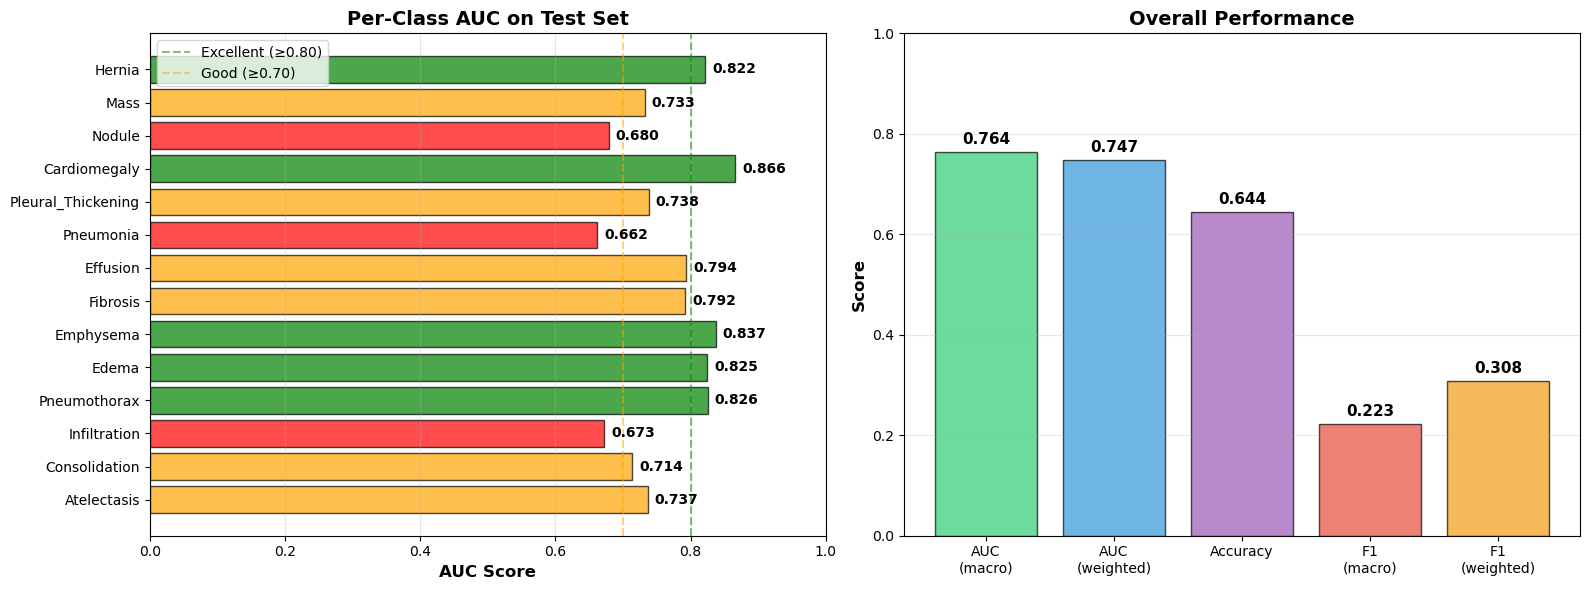

In [15]:
# ========================================================================
# VISUALIZE RESULTS
# ========================================================================

def plot_results(test_results, experiment_name):
    pathologies = list(test_results['per_class_auc'].keys())
    aucs = list(test_results['per_class_auc'].values())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Per-class AUC
    colors = ['green' if a >= 0.80 else 'orange' if a >= 0.70 else 'red' for a in aucs]
    bars = ax1.barh(pathologies, aucs, color=colors, alpha=0.7, edgecolor='black')
    
    for i, (bar, auc) in enumerate(zip(bars, aucs)):
        ax1.text(auc + 0.01, i, f'{auc:.3f}', va='center', fontsize=10, fontweight='bold')
    
    ax1.set_xlabel('AUC Score', fontsize=12, fontweight='bold')
    ax1.set_title('Per-Class AUC on Test Set', fontsize=14, fontweight='bold')
    ax1.set_xlim([0, 1])
    ax1.axvline(0.8, color='green', linestyle='--', alpha=0.5, label='Excellent (≥0.80)')
    ax1.axvline(0.7, color='orange', linestyle='--', alpha=0.5, label='Good (≥0.70)')
    ax1.grid(axis='x', alpha=0.3)
    ax1.legend()
    
    # Overall metrics
    metrics = ['AUC\n(macro)', 'AUC\n(weighted)', 'Accuracy', 'F1\n(macro)', 'F1\n(weighted)']
    values = [
        test_results['test_auc_macro'],
        test_results['test_auc_weighted'],
        test_results['test_accuracy'],
        test_results['test_f1_macro'],
        test_results['test_f1_weighted']
    ]
    
    bars = ax2.bar(metrics, values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12'], 
                   alpha=0.7, edgecolor='black')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax2.set_title('Overall Performance', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 1])
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'experiments/{experiment_name}/results.png', dpi=300, bbox_inches='tight')
    print(f"📊 Saved: experiments/{experiment_name}/results.png")
    plt.show()

plot_results(test_results, experiment_name)


In [ ]:
# ========================================================================
# OPTIONAL: PROGRESS MONITOR (Run this in a separate cell while training)
# ========================================================================

import time as time_module

def monitor_training(experiment_name, check_interval=300):
    """Monitor training progress every 5 minutes"""
    
    print(f"📊 Monitoring: {experiment_name}")
    print(f"Checking every {check_interval//60} minutes...")
    print("Press Ctrl+C to stop monitoring\n")
    
    try:
        while True:
            # Check if best model exists
            model_path = f'experiments/{experiment_name}/best_model.pth'
            if os.path.exists(model_path):
                checkpoint = torch.load(model_path, weights_only=False)
                print(f"[{time_module.strftime('%I:%M %p')}] "
                      f"Epoch {checkpoint['epoch']}: "
                      f"Val AUC = {checkpoint['val_auc_macro']:.4f}")
            else:
                print(f"[{time_module.strftime('%I:%M %p')}] Training not started yet...")
            
            time_module.sleep(check_interval)
    except KeyboardInterrupt:
        print("\n✅ Monitoring stopped")

# Uncomment to use:
monitor_training(experiment_name_full)
